# Deep Learning Classification for IPO Performance Prediction

## Project Overview

This project demonstrates building a deep learning classification model using TensorFlow/Keras to predict whether an Initial Public Offering (IPO) will list at a profit or loss. The dataset contains information on past IPOs in the Indian market sourced from Moneycontrol.

### Dataset Description
- **Source**: Moneycontrol (Indian IPO Market)
- **Records**: 319 IPOs
- **Features**: 9 columns including subscription rates, issue details, and performance metrics
- **Target Variable**: IPO listing performance (profit/loss)

## 1. Environment Setup and Data Loading

In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

# Set style for better visualizations

In [92]:
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
sns.set_style("whitegrid")
sns.set_palette("viridis")

### Loading and Initial Exploration

In [93]:
df = pd.read_csv('https://raw.githubusercontent.com/moscmh/indian_ipo_market/main/Indian_IPO_Market_Data.csv')
print(f"Dataset Shape: {df.shape}")
print(f"Total IPOs: {df.shape[0]}")
print(f"Features: {df.shape[1]}")

Dataset Shape: (319, 9)
Total IPOs: 319
Features: 9


# Display column information

In [94]:
for col in df.columns:
   print(col)

Date 
IPOName
Issue_Size
Subscription_QIB
Subscription_HNI
Subscription_RII
Subscription_Total
Issue_Price
Listing_Gains_Percent


# Display first few rows

In [95]:
df.head()

,Date,IPOName,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Percent
0,03/02/10,Infinite Comp,189.80,48.44,106.02,11.08,43.22,165,11.82
1,08/02/10,Jubilant Food,328.70,59.39,51.95,3.79,31.11,145,-84.21
2,15/02/10,Syncom Health,56.25,0.99,16.60,6.25,5.17,75,17.13
3,15/02/10,Vascon Engineer,199.80,1.12,3.65,0.62,1.22,165,-11.28
4,19/02/10,Thangamayil,0.00,0.52,1.52,2.26,1.12,75,-5.20


# Check for missing values

In [96]:
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
Date                     0
IPOName                  0
Issue_Size               0
Subscription_QIB         0
Subscription_HNI         0
Subscription_RII         0
Subscription_Total       0
Issue_Price              0
Listing_Gains_Percent    0
dtype: int64


# Basic statistics

In [97]:
print("\nDataset Statistics:")
print(df.describe(include='all'))


Dataset Statistics:
           Date           IPOName    Issue_Size  Subscription_QIB  \
count        319              319    319.000000        319.000000   
unique       287              319           NaN               NaN   
top     16/08/21  Electronics Mar           NaN               NaN   
freq           4                1           NaN               NaN   
mean         NaN              NaN   1192.859969         25.684138   
std          NaN              NaN   2384.643786         40.716782   
min          NaN              NaN      0.000000          0.000000   
25%          NaN              NaN    169.005000          1.150000   
50%          NaN              NaN    496.250000          4.940000   
75%          NaN              NaN   1100.000000         34.635000   
max          NaN              NaN  21000.000000        215.450000   

        Subscription_HNI  Subscription_RII  Subscription_Total  Issue_Price  \
count         319.000000        319.000000          319.000000   319.00

# Check data types

In [98]:
print("\nData Types:")
print(df.dtypes)


Data Types:
Date                      object
IPOName                   object
Issue_Size               float64
Subscription_QIB         float64
Subscription_HNI         float64
Subscription_RII         float64
Subscription_Total       float64
Issue_Price                int64
Listing_Gains_Percent    float64
dtype: object


### Key Findings:
- No missing values in any column
- All numerical features have valid ranges
- High variance in subscription rates indicates potential outliers
- Dataset spans from 2010 to recent years

## 3. Target Variable Creation and Analysis

# Analyzing the continuous target

In [99]:
print("Listing Gains Distribution:")
print(df['Listing_Gains_Percent'].describe())

Listing Gains Distribution:
count    319.000000
mean       4.742696
std       47.650946
min      -97.150000
25%      -11.555000
50%        1.810000
75%       25.310000
max      270.400000
Name: Listing_Gains_Percent, dtype: float64


# Create binary target variable

In [100]:
df['Listing_Gains_Profit'] = np.where(df['Listing_Gains_Percent'] > 0, 1, 0)

# Analyze target distribution

In [101]:
profit_stats = df['Listing_Gains_Profit'].value_counts(normalize=True)
print("\nTarget Variable Distribution:")
print(f"Profitable IPOs: {profit_stats[1]:.1%}")
print(f"Loss-making IPOs: {profit_stats[0]:.1%}")


Target Variable Distribution:
Profitable IPOs: 54.5%
Loss-making IPOs: 45.5%


**Target Balance**: 54.5% profitable vs 45.5% loss-making IPOs - reasonably balanced dataset.

## 4. Data Visualization

### 4.1 Target Variable Distribution

# Count plot & Pie Chart

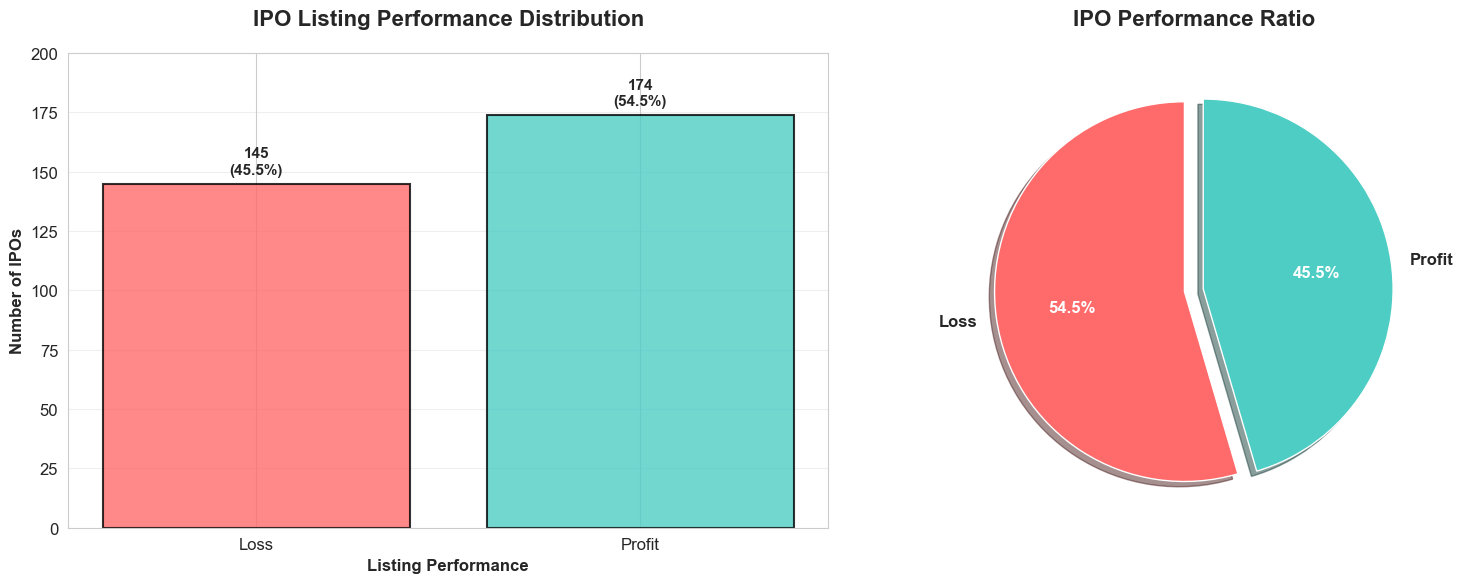

In [102]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
colors = ['#FF6B6B', '#4ECDC4']
counts = df['Listing_Gains_Profit'].value_counts().sort_index()
bars = ax1.bar(['Loss', 'Profit'], counts.values, color=colors, alpha=0.8,
edgecolor='black', linewidth=1.5)
for i, (bar, value) in enumerate(zip(bars, counts.values)):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 3, 
             f'{value}\n({value/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

ax1.set_title('IPO Listing Performance Distribution', fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Listing Performance', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of IPOs', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim(0, max(counts.values) * 1.15)

profit_counts = df['Listing_Gains_Profit'].value_counts()
wedges, texts, autotexts = ax2.pie(profit_counts.values, labels=['Loss', 'Profit'],
autopct='%1.1f%%', colors=colors, startangle=90,
explode=(0.05, 0.05), shadow=True,
textprops={'fontsize': 12, 'fontweight': 'bold'})
ax2.set_title('IPO Performance Ratio', fontsize=16, fontweight='bold', pad=20)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

plt.tight_layout()
plt.show()


# Distribution plots with subplots

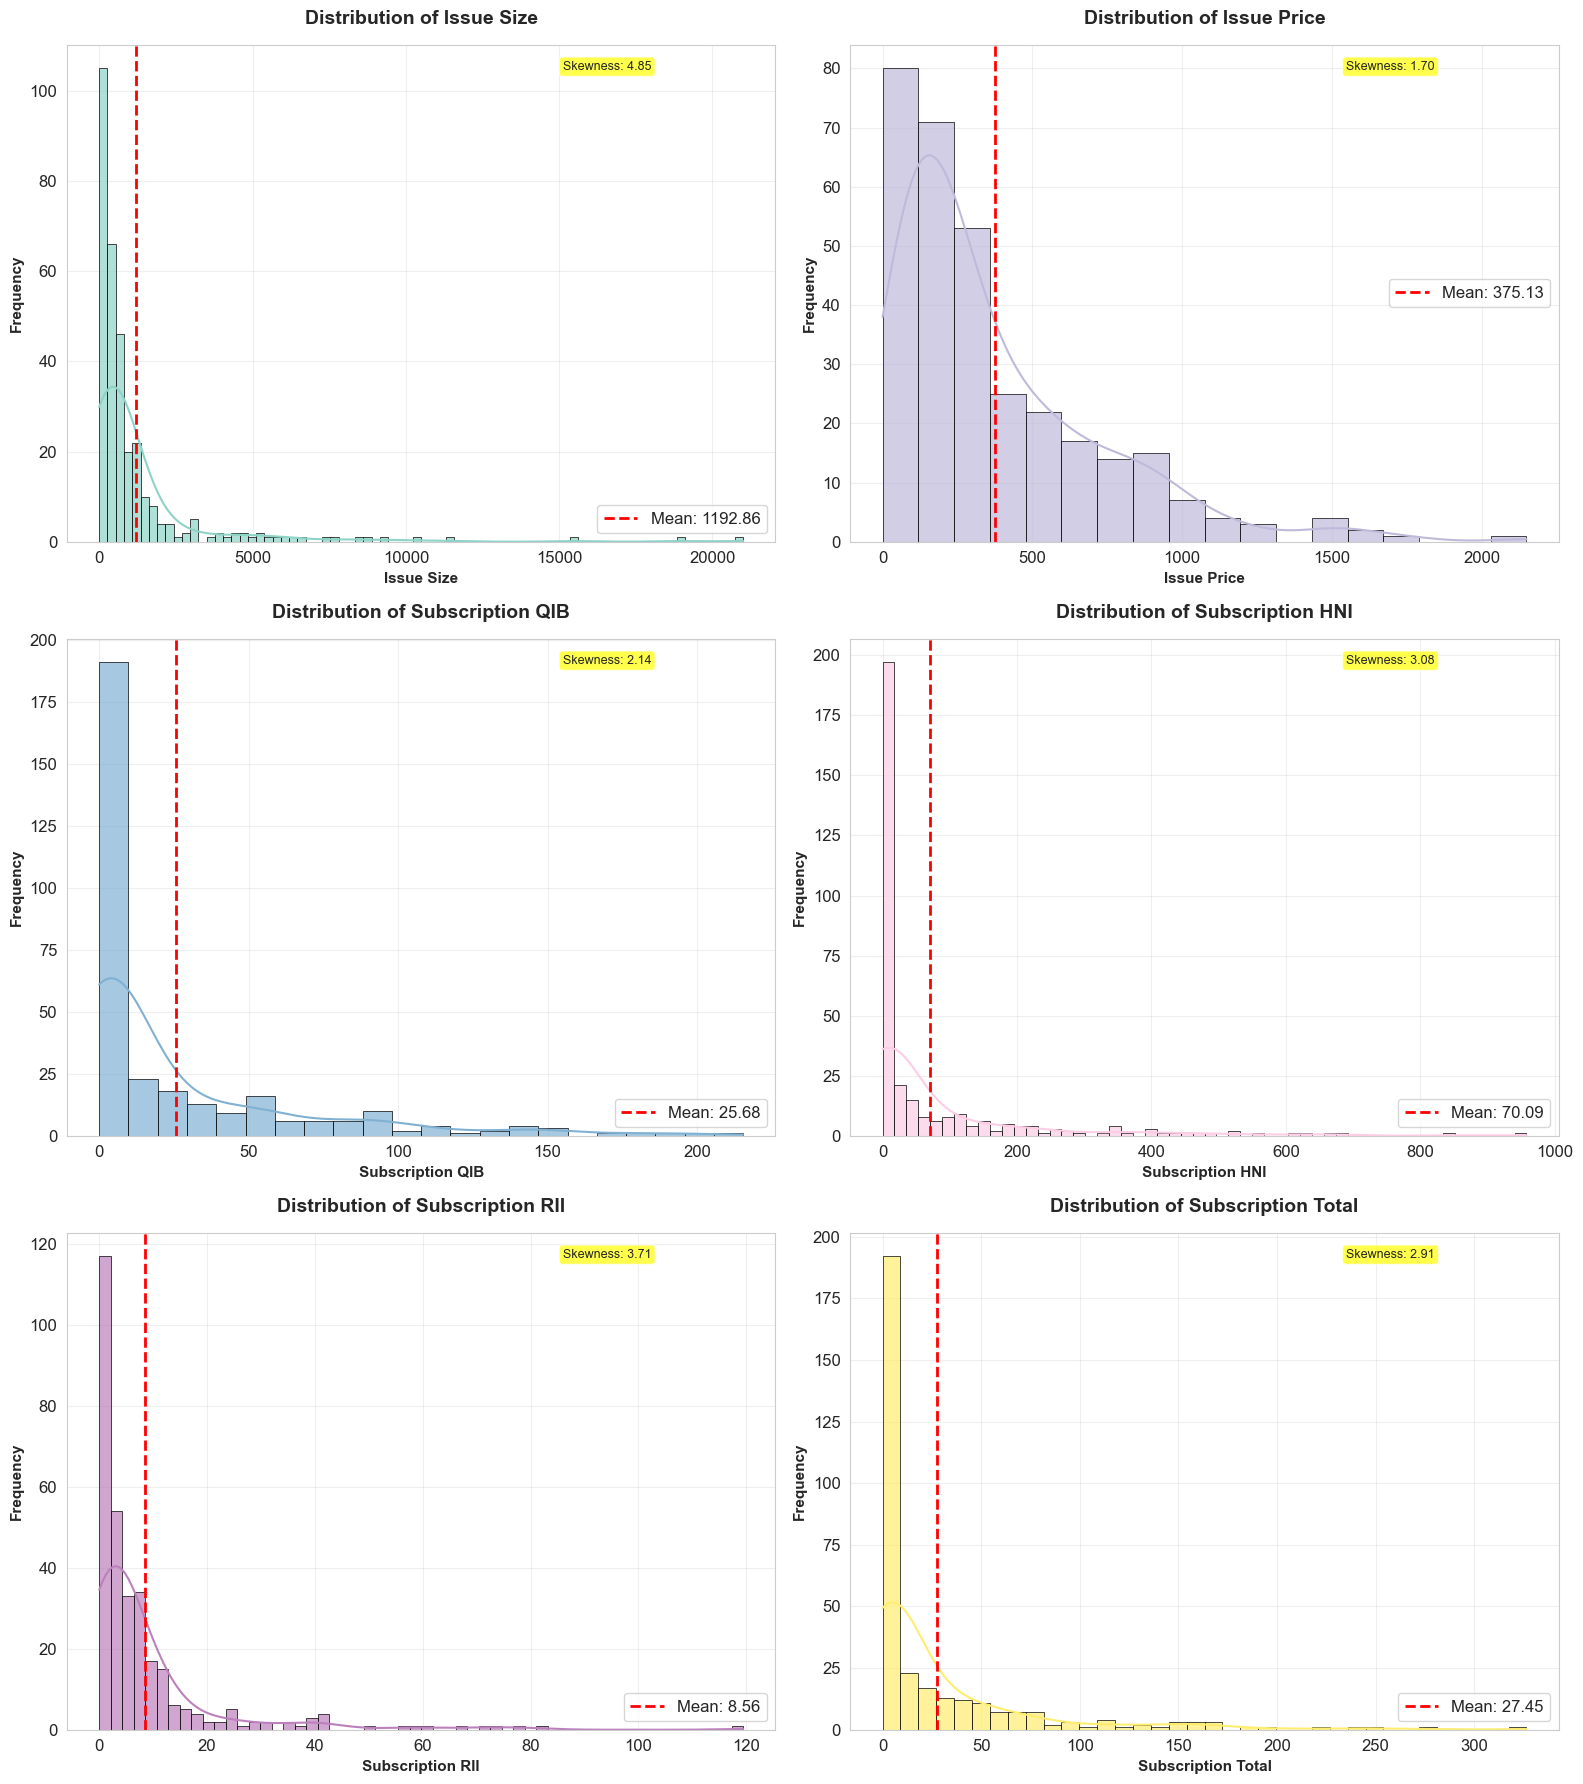

In [103]:
fig, axes = plt.subplots(3, 2, figsize=(16, 18))
axes = axes.ravel()
numeric_cols = ['Issue_Size', 'Issue_Price', 'Subscription_QIB',
'Subscription_HNI', 'Subscription_RII', 'Subscription_Total']
colors = plt.cm.Set3(np.linspace(0, 1, len(numeric_cols)))

for i, (col, color) in enumerate(zip(numeric_cols, colors)):
    # Enhanced histogram with KDE overlay
    sns.histplot(data=df, x=col, kde=True, alpha=0.7, ax=axes[i], 
                color=color, edgecolor='black', linewidth=0.5)
    
    # Add mean line
    mean_val = df[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, 
                   label=f'Mean: {mean_val:.2f}')
    
    axes[i].set_title(f'Distribution of {col.replace("_", " ")}', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel(col.replace("_", " "), fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    axes[i].legend()
    
    # Add skewness information
    skew_val = df[col].skew()
    axes[i].text(0.7, 0.95, f'Skewness: {skew_val:.2f}', 
                transform=axes[i].transAxes, bbox=dict(boxstyle="round,pad=0.3", 
                facecolor="yellow", alpha=0.7), fontsize=9)

plt.tight_layout()
plt.show()

# Skewness summary

In [104]:
print("Skewness Analysis:")
for col in numeric_cols:
    skew_val = df[col].skew()
    if abs(skew_val) > 2:
        skew_level = "Highly skewed"
    elif abs(skew_val) > 1:
        skew_level = "Moderately skewed"
    else:
        skew_level = "Approximately normal"
    print(f"{col}: {skew_val:.2f} ({skew_level})")

Skewness Analysis:
Issue_Size: 4.85 (Highly skewed)
Issue_Price: 1.70 (Moderately skewed)
Subscription_QIB: 2.14 (Highly skewed)
Subscription_HNI: 3.08 (Highly skewed)
Subscription_RII: 3.71 (Highly skewed)
Subscription_Total: 2.91 (Highly skewed)


# Box plots for outlier detection

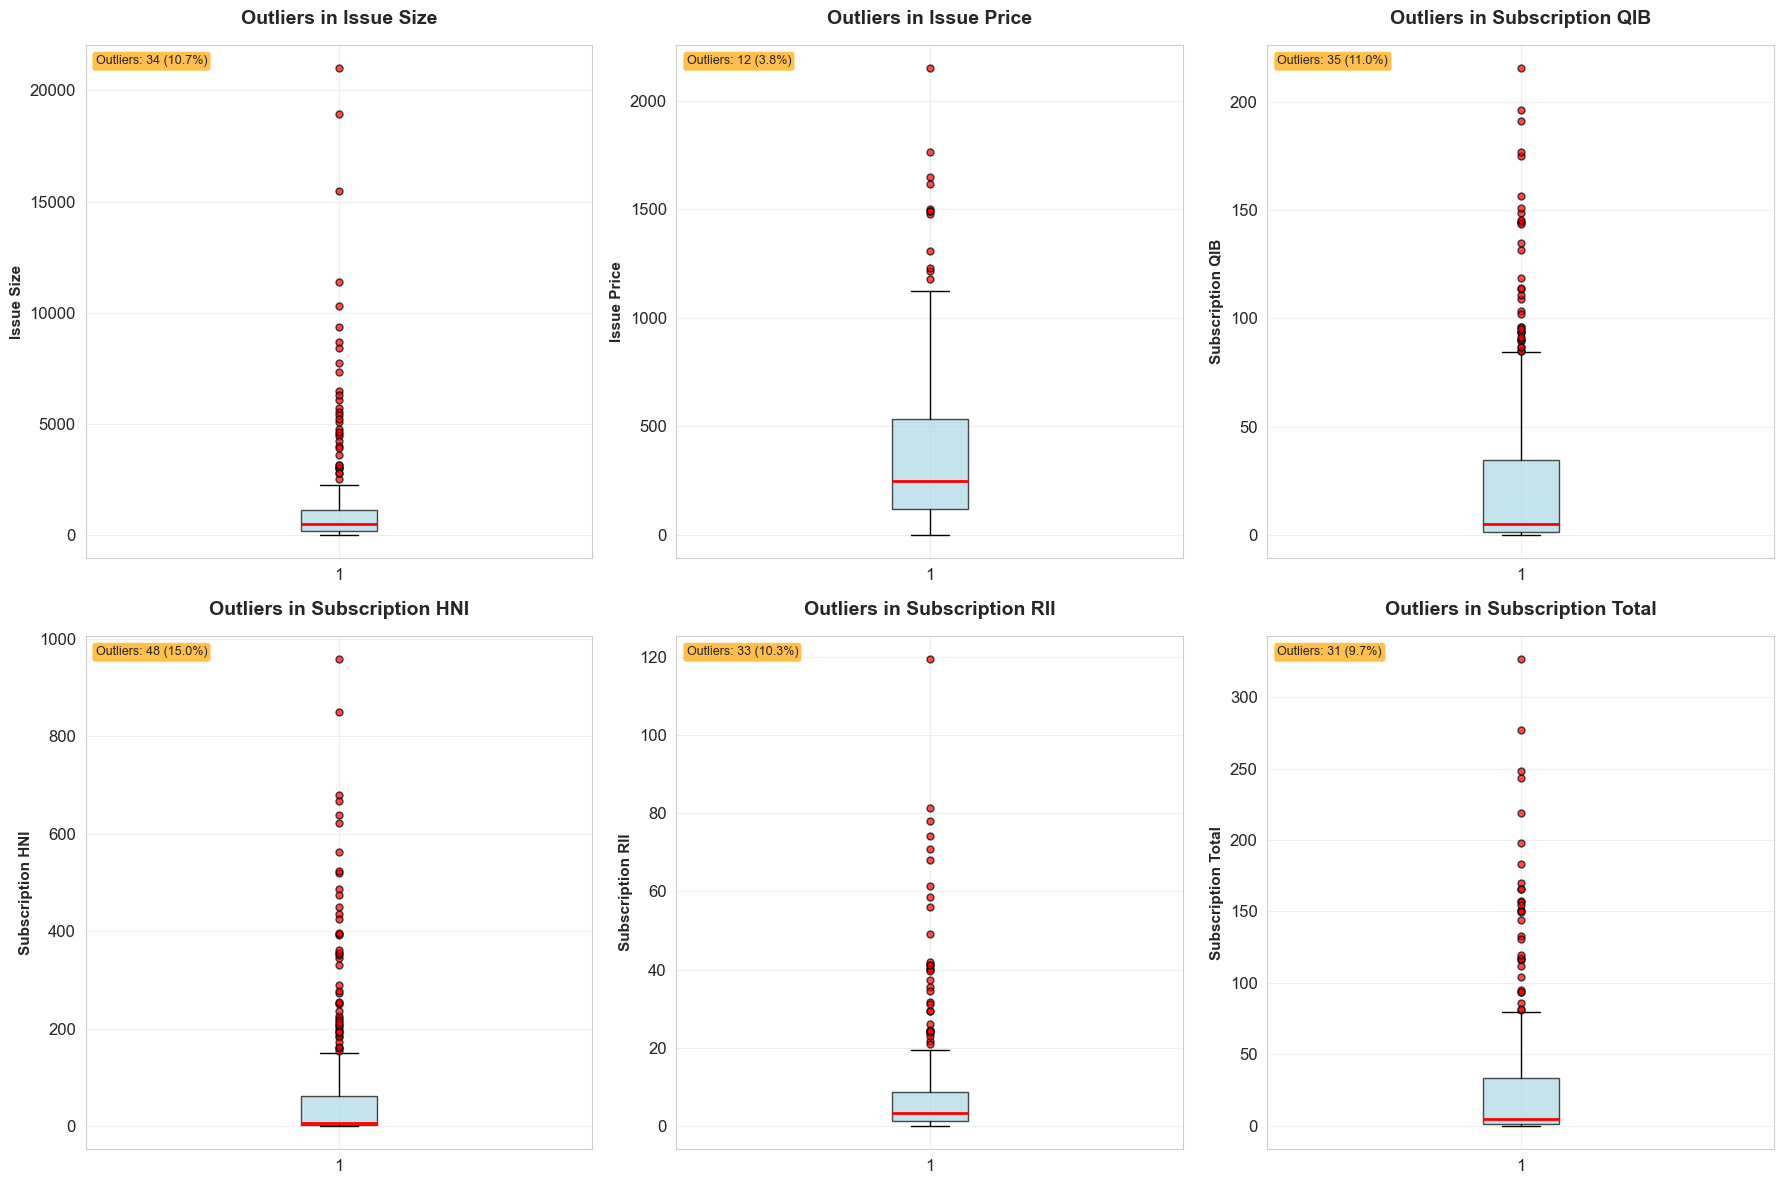

In [105]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Box plot with custom styling
    bp = axes[i].boxplot(df[col], patch_artist=True, 
                        boxprops=dict(facecolor='lightblue', alpha=0.7),
                        medianprops=dict(color='red', linewidth=2),
                        flierprops=dict(marker='o', markerfacecolor='red', 
                                      markersize=5, alpha=0.7))
    
    axes[i].set_title(f'Outliers in {col.replace("_", " ")}', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[i].set_ylabel(col.replace("_", " "), fontsize=11, fontweight='bold')
    axes[i].grid(True, alpha=0.3)
    
    # Add quartile information
    q1, median, q3 = np.percentile(df[col], [25, 50, 75])
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
    outlier_pct = len(outliers) / len(df) * 100
    
    axes[i].text(0.02, 0.98, f'Outliers: {len(outliers)} ({outlier_pct:.1f}%)', 
                transform=axes[i].transAxes, 
                bbox=dict(boxstyle="round,pad=0.3", facecolor="orange", alpha=0.7), 
                fontsize=9, verticalalignment='top')

plt.tight_layout()
plt.show()

### 4.4 Feature Relationships and Correlation Analysis

# Correlation heatmap

In [106]:
plt.figure(figsize=(14, 10))



<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

# Calculate correlation matrix

In [107]:
correlation_matrix = df[numeric_cols + ['Listing_Gains_Profit']].corr()

# Create mask for upper triangle

In [108]:
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Heatmap

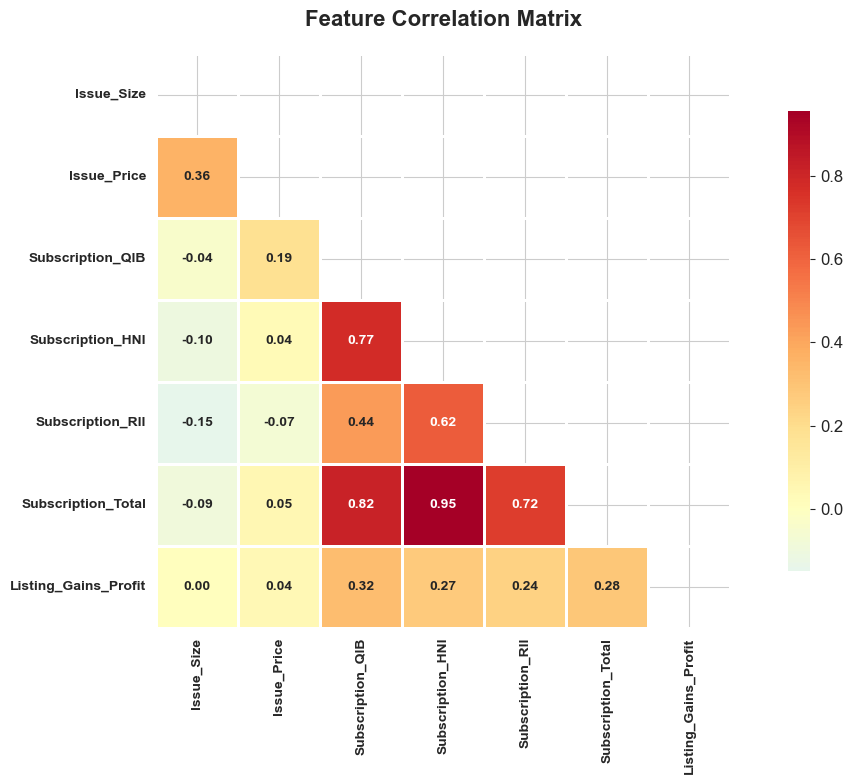

In [109]:
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r',
center=0, square=True, linewidths=1, cbar_kws={"shrink": .8},
fmt='.2f', annot_kws={'fontsize': 10, 'fontweight': 'bold'})
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(fontsize=10, fontweight='bold')
plt.yticks(fontsize=10, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify strong correlations

In [110]:
print("Strong Correlations (|r| > 0.5):")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.5:
            print(f"{correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: {corr_val:.3f}")

Strong Correlations (|r| > 0.5):
Subscription_QIB ↔ Subscription_HNI: 0.774
Subscription_QIB ↔ Subscription_Total: 0.816
Subscription_HNI ↔ Subscription_RII: 0.623
Subscription_HNI ↔ Subscription_Total: 0.955
Subscription_RII ↔ Subscription_Total: 0.719


# Feature comparison by IPO performance

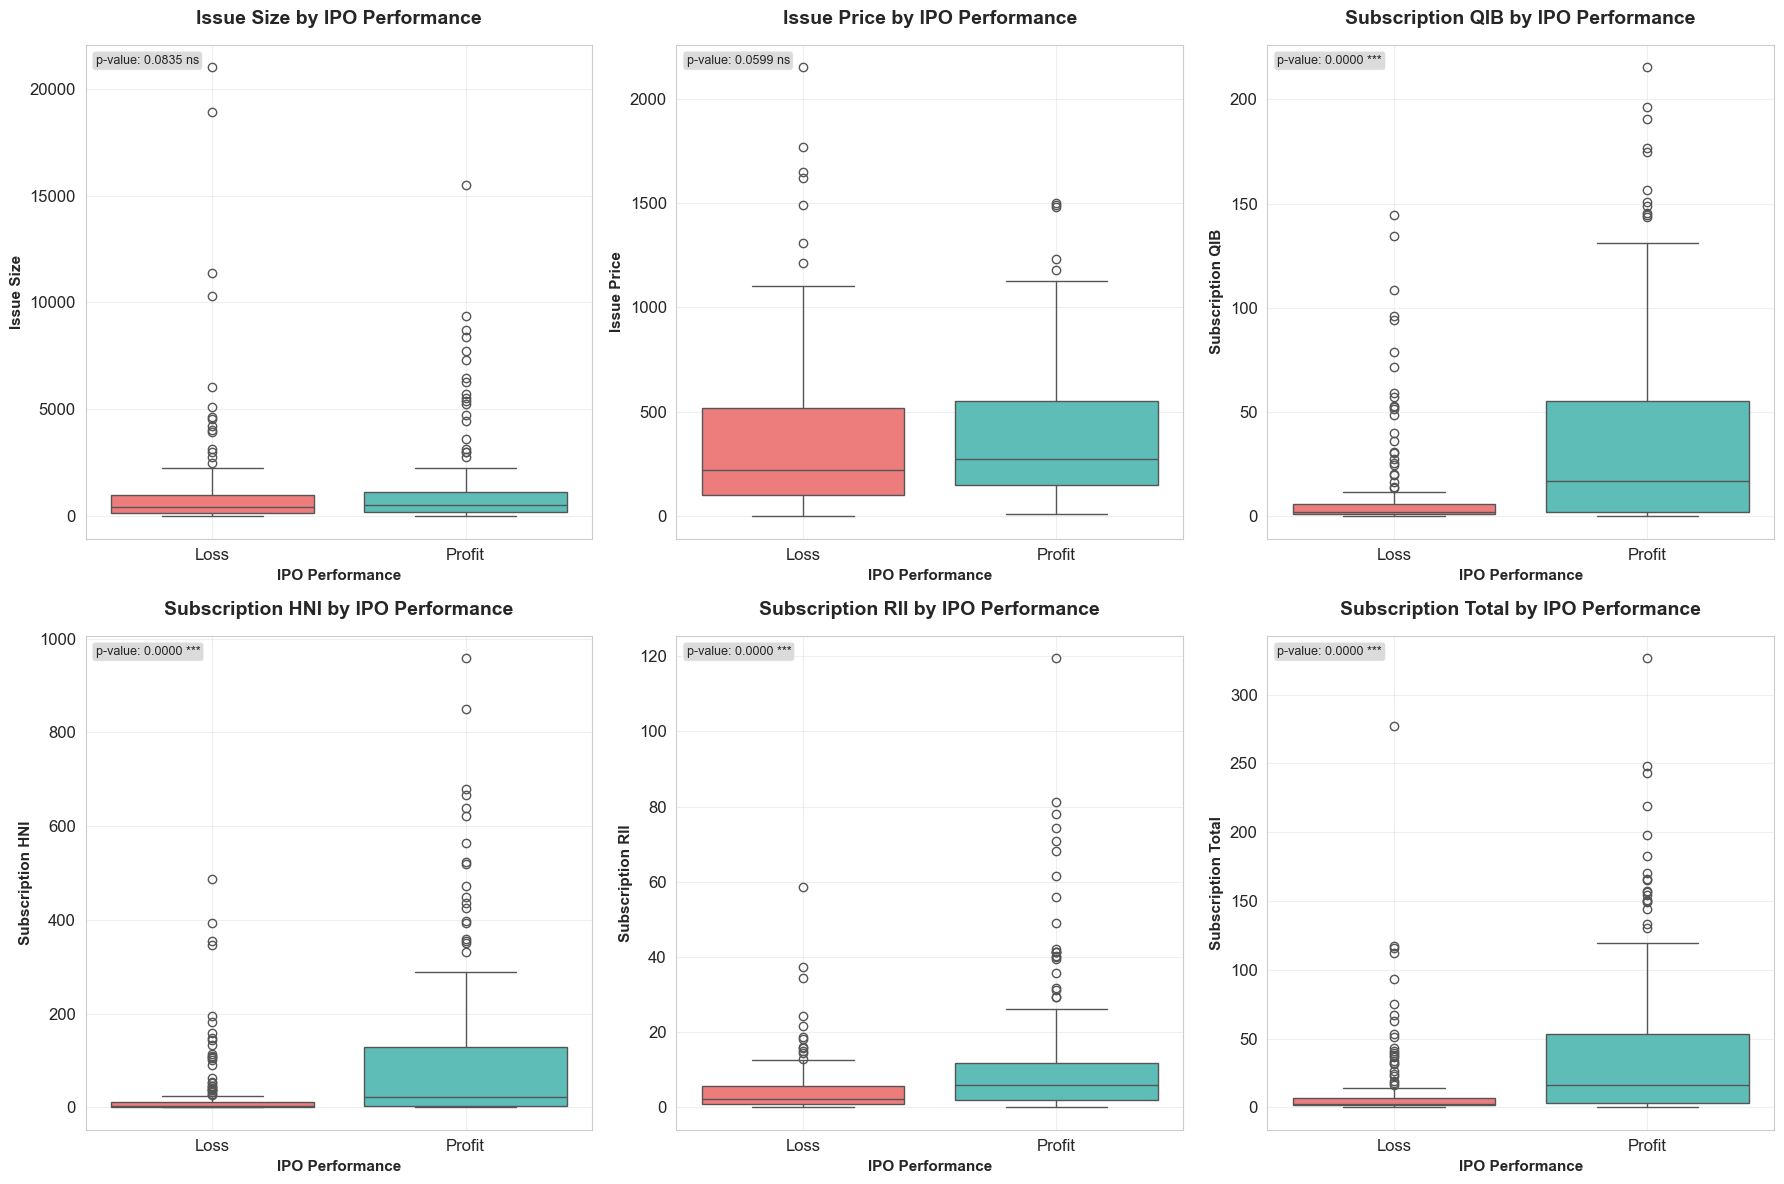

In [111]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_cols):
    # Box plot comparing profit vs loss IPOs
    sns.boxplot(data=df, x='Listing_Gains_Profit', y=col, ax=axes[i],
                hue='Listing_Gains_Profit', palette=['#FF6B6B', '#4ECDC4'], legend=False)
    
    axes[i].set_title(f'{col.replace("_", " ")} by IPO Performance', 
                     fontsize=14, fontweight='bold', pad=15)
    axes[i].set_xlabel('IPO Performance', fontsize=11, fontweight='bold')
    axes[i].set_ylabel(col.replace("_", " "), fontsize=11, fontweight='bold')
    
    # Fix for the xticklabels warning - set ticks first
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(['Loss', 'Profit'])
    axes[i].grid(True, alpha=0.3)
    
    # Add statistical test result
    from scipy.stats import mannwhitneyu
    loss_data = df[df['Listing_Gains_Profit'] == 0][col]
    profit_data = df[df['Listing_Gains_Profit'] == 1][col]
    
    try:
        stat, p_value = mannwhitneyu(loss_data, profit_data, alternative='two-sided')
        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
        axes[i].text(0.02, 0.98, f'p-value: {p_value:.4f} {significance}', 
                    transform=axes[i].transAxes, 
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray", alpha=0.8), 
                    fontsize=9, verticalalignment='top')
    except:
        pass

plt.tight_layout()
plt.show()

### 4.6 Additional Insights Visualization

# Scatter plot matrix for key relationships

<Figure size 1200x1000 with 0 Axes>

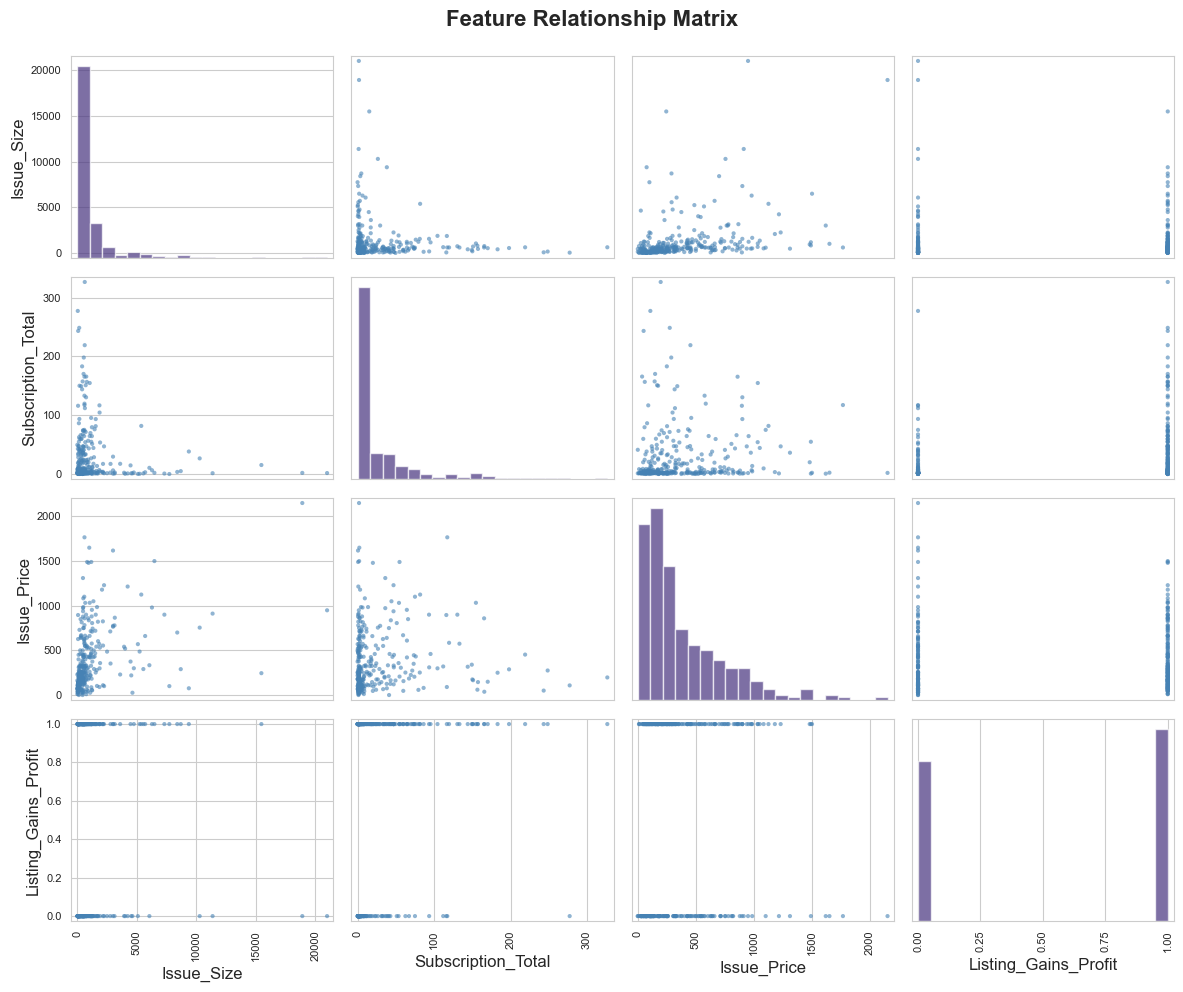

In [112]:
from pandas.plotting import scatter_matrix
key_features = ['Issue_Size', 'Subscription_Total', 'Issue_Price', 'Listing_Gains_Profit']
scatter_df = df[key_features].copy()
fig = plt.figure(figsize=(12, 10))
scatter_matrix(scatter_df, alpha=0.6, figsize=(12, 10), diagonal='hist',
color='steelblue', hist_kwds={'bins': 20, 'alpha': 0.7})
plt.suptitle('Feature Relationship Matrix', fontsize=16, fontweight='bold', y=0.99)
plt.tight_layout()
plt.show()

## 5. Data Preprocessing and Outlier Treatment

### 5.1 Systematic Outlier Treatment

# Function to apply IQR method for outlier treatment

In [113]:
def treat_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    print(f"\n{column}:")
    print(f"  IQR = {IQR:.2f}")
    print(f"  Lower bound = {lower_bound:.2f}")
    print(f"  Upper bound = {upper_bound:.2f}")
    print(f"  Outliers before treatment: {((df[column] < lower_bound) | (df[column] > upper_bound)).sum()}")
    
    # Clip outliers
    df[column] = df[column].clip(lower_bound, upper_bound)
    
    return df

# Create a copy for preprocessing

In [114]:
df_processed = df.copy()

# Remove non-predictive columns

In [115]:
columns_to_drop = ['Date ', 'IPOName', 'Listing_Gains_Percent']
for col in columns_to_drop:
    if col in df_processed.columns:
        df_processed = df_processed.drop(col, axis=1)



# Apply outlier treatment to all numeric features

In [116]:
numeric_features = ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 
                   'Subscription_RII', 'Subscription_Total']

for feature in numeric_features:
    if feature in df_processed.columns:
        df_processed = treat_outliers_iqr(df_processed, feature)


Issue_Size:
  IQR = 931.00
  Lower bound = -1227.49
  Upper bound = 2496.49
  Outliers before treatment: 34

Subscription_QIB:
  IQR = 33.49
  Lower bound = -49.08
  Upper bound = 84.86
  Outliers before treatment: 35

Subscription_HNI:
  IQR = 60.84
  Lower bound = -90.00
  Upper bound = 153.35
  Outliers before treatment: 48

Subscription_RII:
  IQR = 7.33
  Lower bound = -9.72
  Upper bound = 19.60
  Outliers before treatment: 33

Subscription_Total:
  IQR = 31.75
  Lower bound = -45.98
  Upper bound = 81.02
  Outliers before treatment: 31


# Display final dataset info

In [117]:
print(f"\nFinal dataset shape: {df_processed.shape}")
print("\nFinal dataset info:")
print(df_processed.info())


Final dataset shape: (319, 7)

Final dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Issue_Size            319 non-null    float64
 1   Subscription_QIB      319 non-null    float64
 2   Subscription_HNI      319 non-null    float64
 3   Subscription_RII      319 non-null    float64
 4   Subscription_Total    319 non-null    float64
 5   Issue_Price           319 non-null    int64  
 6   Listing_Gains_Profit  319 non-null    int64  
dtypes: float64(5), int64(2)
memory usage: 17.6 KB
None


### 5.2 Feature Normalization

# Prepare features and target

In [118]:
target_variable = ['Listing_Gains_Profit']
predictors = [col for col in df_processed.columns if col not in target_variable]
print(f"Predictors: {predictors}")
print(f"Target: {target_variable}")

Predictors: ['Issue_Size', 'Subscription_QIB', 'Subscription_HNI', 'Subscription_RII', 'Subscription_Total', 'Issue_Price']
Target: ['Listing_Gains_Profit']


# Normalize predictors using min-max scaling

In [119]:
for col in predictors:
    original_min = df_processed[col].min()
    original_max = df_processed[col].max()
    print(f"{col}: [{original_min:.2f}, {original_max:.2f}] → [0.00, 1.00]")

Issue_Size: [0.00, 2496.49] → [0.00, 1.00]
Subscription_QIB: [0.00, 84.86] → [0.00, 1.00]
Subscription_HNI: [0.00, 153.35] → [0.00, 1.00]
Subscription_RII: [0.00, 19.60] → [0.00, 1.00]
Subscription_Total: [0.00, 81.02] → [0.00, 1.00]
Issue_Price: [0.00, 2150.00] → [0.00, 1.00]


# Apply min-max normalization

In [120]:
df_processed[predictors] = df_processed[predictors] / df_processed[predictors].max()

df_processed.describe()

,Issue_Size,Subscription_QIB,Subscription_HNI,Subscription_RII,Subscription_Total,Issue_Price,Listing_Gains_Profit
count,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000,319.000000
mean,0.305854,0.253601,0.263157,0.309232,0.252489,0.174478,0.545455
std,0.308308,0.342961,0.374477,0.315147,0.335939,0.164604,0.498712
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.067697,0.013551,0.008184,0.065051,0.020304,0.055349,0.000000
50%,0.198779,0.058212,0.033061,0.174490,0.060849,0.116279,1.000000
75%,0.440618,0.408131,0.404910,0.439031,0.412182,0.249302,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 6. Deep Learning Model Development

### 6.1 Data Splitting Strategy

# Prepare data for modeling

In [121]:
X = df_processed[predictors].values
y = df_processed[target_variable].values


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=100)
print(X_train.shape); print(X_test.shape)

(223, 6)
(96, 6)


### 6.2 Neural Network Architecture Design

In [122]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(32, input_shape = (X_train.shape[1],), activation = 'relu'))
model.add(tf.keras.layers.Dense(16, activation= 'relu'))
model.add(tf.keras.layers.Dense(8, activation= 'relu'))
model.add(tf.keras.layers.Dense(4, activation= 'relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))   

C:\Users\Pranav\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 6.3 Model Compilation and Training Setup

In [123]:

model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 929 (3.63 KB)

 Trainable params: 929 (3.63 KB)

 Non-trainable params: 0 (0.00 B)

None


# Train the model with validation split

In [124]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5605 - loss: 0.6887
Epoch 2/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5561 - loss: 0.6845 
Epoch 3/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6800 
Epoch 4/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5561 - loss: 0.6753 
Epoch 5/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6700 
Epoch 6/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6643  
Epoch 7/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6584 
Epoch 8/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6528 
Epoch 9/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5561 - loss: 0.6477 
Epoch 10/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5561 - loss: 0.6428 
Epoch 11/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5561 - loss: 0.6391 
Epoch 12/250
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5561 - lo

# Print training summary

In [127]:
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]
print("\nTraining Summary:")
print("=" * 20)
print(f"Final Training Accuracy: {final_train_acc:.4f}")
print(f"Final Validation Accuracy: {final_val_acc:.4f}")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Validation Loss: {final_val_loss:.4f}")


Training Summary:
Final Training Accuracy: 0.7079
Final Validation Accuracy: 0.6889
Final Training Loss: 0.5260
Final Validation Loss: 0.6779


## 7. Comprehensive Model Evaluation

### 7.1 Performance Metrics

# Evaluate on training and test sets

In [130]:
train_results = model.evaluate(X_train, y_train)
test_results = model.evaluate(X_test, y_test)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7354 - loss: 0.5174 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7188 - loss: 0.6921
